#  Getting started with PyMC3

https://docs.pymc.io/notebooks/getting_started.html

Authors: John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck

Note: This text is based on the PeerJ CS publication on PyMC3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

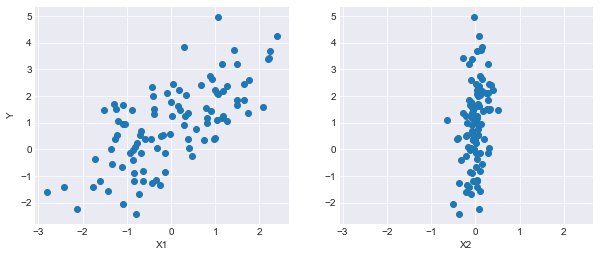

In [2]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [3]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

/home/perry/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Running on PyMC3 v3.7


In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

I do not get this stuff below. Can someone dumb it down?

We call the Normal constructor to create a random variable to use as a normal prior. The first argument is always the name of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case mu, the mean, and sd, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution’s parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and many others, are available in PyMC3.

The beta variable has an additional shape argument to denote it as a vector-valued parameter of size 2. The shape argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (e.g. shape=(5,7) makes random variable that takes on 5 by 7 matrix values).

Detailed notes about distributions, sampling methods and other PyMC3 functions are available in the API documentation.

https://docs.pymc.io/api.html

In [5]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

/home/perry/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1234.61it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

In [6]:
map_estimate = pm.find_MAP(model=basic_model, method='powell')

map_estimate

/home/perry/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/perry/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:501: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149.47, ||grad|| = 13.248: 100%|██████████| 177/177 [00:00<00:00, 1341.20it/s] 


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma_log__': array(-0.03492212),
 'sigma': array(0.96568062)}

In [7]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1190.56draws/s]


In [8]:
trace['alpha'][-5:]

array([0.86038143, 0.88875012, 0.91392392, 0.99143432, 0.86691189])

In [9]:
with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:12<00:00, 901.02draws/s]


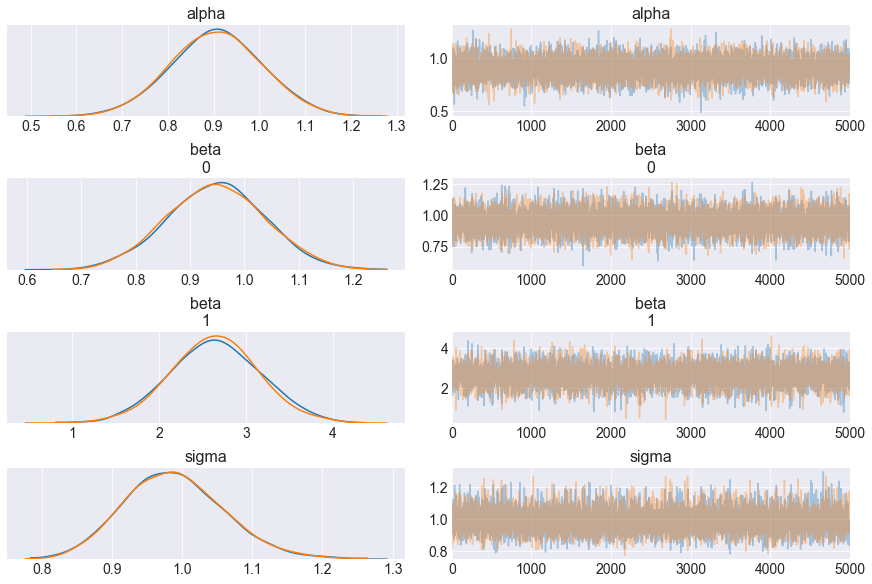

In [10]:
pm.traceplot(trace);

In [11]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.00,0.72,1.11,9283.21,1.0
beta__0,0.95,0.09,0.00,0.77,1.12,10340.59,1.0
beta__1,2.64,0.51,0.01,1.67,3.71,7468.93,1.0
sigma,0.99,0.07,0.00,0.85,1.12,8343.05,1.0


In [12]:
import pandas as pd

returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)

len(returns)

401

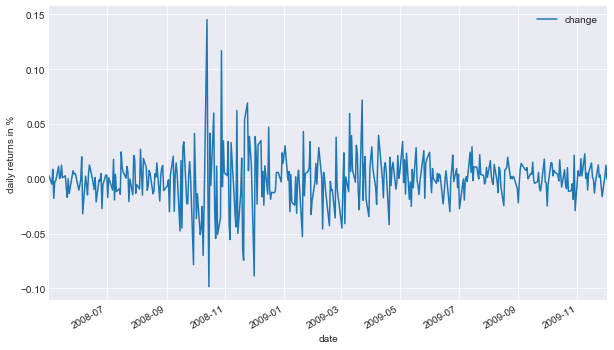

In [13]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [14]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=returns['change'])

In [15]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:41<00:00, 30.92draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


/home/perry/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


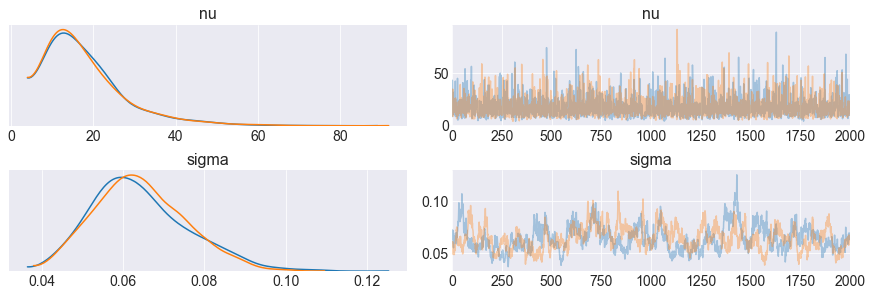

In [16]:
pm.traceplot(trace, varnames=['nu', 'sigma']);

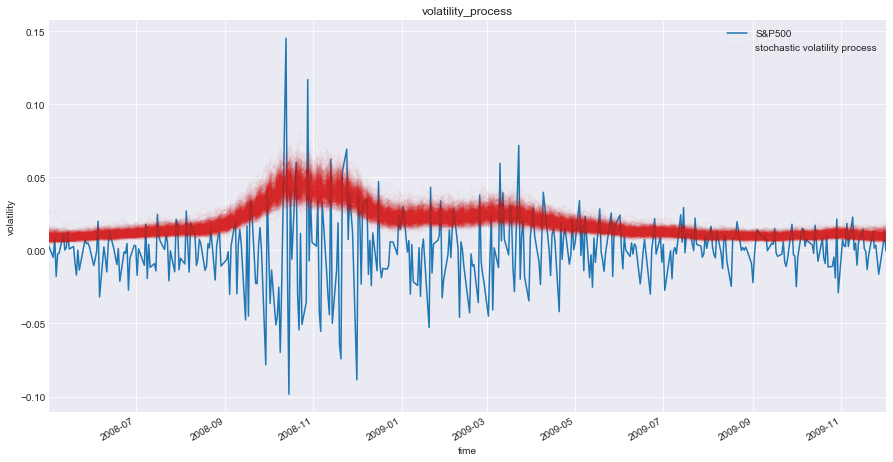

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

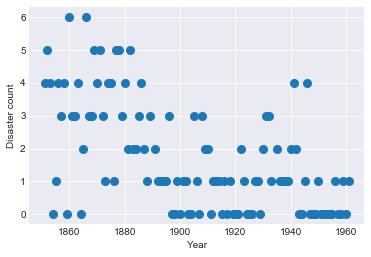

In [18]:
#import pandas as pd
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [19]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

/home/perry/anaconda3/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


In [21]:

with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:25<00:00, 830.18draws/s] 
The number of effective samples is smaller than 10% for some parameters.


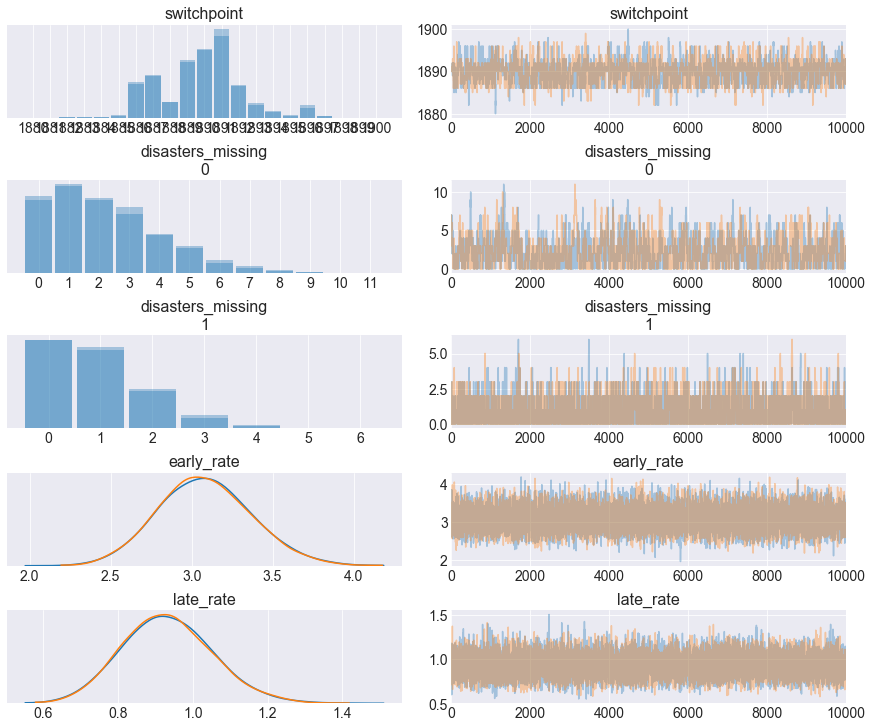

In [22]:
pm.traceplot(trace);

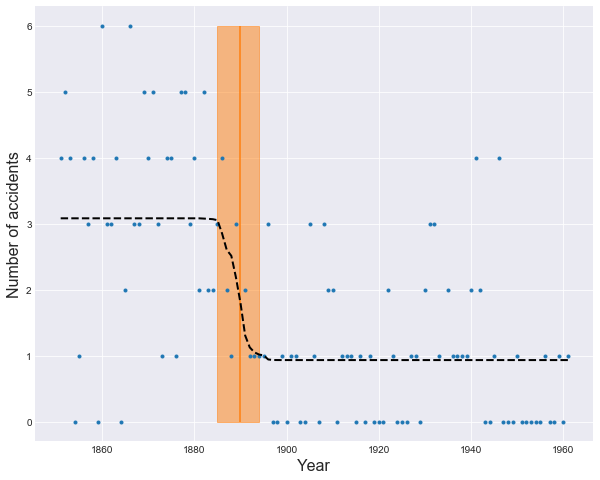

In [23]:

plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

In [24]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else :
        return (-value + 1) % 3

with pm.Model() as model_deterministic:
    a = pm.Poisson('a', 1)
    b = crazy_modulo3(a)

Similarly, the library of statistical distributions in PyMC3 is not exhaustive, but PyMC3 allows for the creation of user-defined functions for an arbitrary probability distribution. For simple statistical distributions, the DensityDist function takes as an argument any function that calculates a log-probability log(p(x)). This function may employ other random variables in its calculation. Here is an example inspired by a blog post by Jake Vanderplas on which priors to use for a linear regression (Vanderplas, 2014).

In [25]:
import theano.tensor as tt

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)

    # Create custom densities
    beta = pm.DensityDist('beta', lambda value: -1.5 * tt.log(1 + value**2), testval=0)
    eps = pm.DensityDist('eps', lambda value: -tt.log(tt.abs_(value)), testval=1)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)

NameError: name 'X' is not defined

Thomas Wiecki • 5 years ago • edited

Here is the code to implement this model in PyMC3:

PG: I adjusted this code to reference "pm," which was already imported.


but it still has the problem of an undefined "xdata."

In [33]:
#import pymc
import theano.tensor as T

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    # Create custom densities
    beta = pm.DensityDist('slope', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    sigma = pm.DensityDist('sigma', lambda value: -T.log(T.abs_(value)), testval=1)
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * xdata, sd=sigma, observed=ydata)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) # Instantiate sampler
    trace = pm.sample(10000, step, start=start, progressbar=False) 

NameError: name 'xdata' is not defined

https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/

For more complex distributions, one can create a subclass of Continuous or Discrete and provide the custom logp function, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using as_op or inheriting from theano.Op.

Implementing the beta variable above as a Continuous subclass is shown below, along with a sub-function.

In [34]:
class Beta(pm.Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)


def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

Generalized Linear Models¶
Generalized Linear Models (GLMs) are a class of flexible models that are widely used to estimate regression relationships between a single outcome variable and one or multiple predictors. Because these models are so common, PyMC3 offers a glm submodule that allows flexible creation of various GLMs with an intuitive R-like syntax that is implemented via the patsy module.

The glm submodule requires data to be included as a pandas DataFrame. Hence, for our linear regression example:

In [35]:
# Convert X and Y to a pandas DataFrame
df = pd.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

In [36]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x2, x1, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 842.06draws/s] 


In [37]:
from pymc3.glm.families import Binomial

df_logistic = pd.DataFrame({'x1': X1, 'y': Y > np.median(Y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x1', df_logistic, family=Binomial())